In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import sparse
from ProtoRegNet import ProtoRegNet, SaveProtoRegNetVars
from sklearn.datasets import make_moons
from prototype_utils import MLPClassifier
from skorch_utils import EarlyStopping, NaNStopping, MLP
from skorch.callbacks import LRScheduler

from sklearn.decomposition import PCA

random_state=0


# Testing LDMNet on Toy data

To verify the implementation of LDMNet, this notebook includes some experiments with toy data.

In [27]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

from scipy import sparse
from LDMM import LDMNetSkorch, SaveLDMNetVars
%run LDMM_plot_utils.py
from sklearn.datasets import make_moons
from prototype_utils import MLPClassifier
from skorch_utils import (EarlyStopping, NaNStopping, MLP, NNClassifier, 
                          SaveWeights, LRScheduler, learning_curve)
from skorch.utils import to_numpy

from scipy.stats import uniform, reciprocal
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.decomposition import PCA

import pandas as pd

random_state=0
plt.rcParams['image.cmap'] = 'RdBu'

## Generating data: S curve (2D surface on 3D coords)
Toy data for this experiments is an S shaped surface generated by `sklearn`'s function `make_s_curve`.
Each point is returned with a continuous value as label, which is quantized in two discrete values to generate a binary classification problem. Continuous values will be kept only for visualization purposes.

We generate 100 points with no noise. Bellow, 3D plots of the surface and a 2D plot made via PCA dimensionality reduction.


In [28]:
from sklearn.datasets import make_blobs
n_features = 64
N = n_classes = 10
centers = n_classes*2
n_samples = n_classes*50
n_proto = centers
n_proto_per_class = n_proto // n_classes

X, y = make_blobs(n_samples, n_features, centers, 
                  cluster_std=10.0,random_state=random_state)
X = X.astype(np.float32)
y = np.array([l//2 for l in y], dtype=np.int64)
pca = PCA(3)
X3d = pca.fit_transform(X)

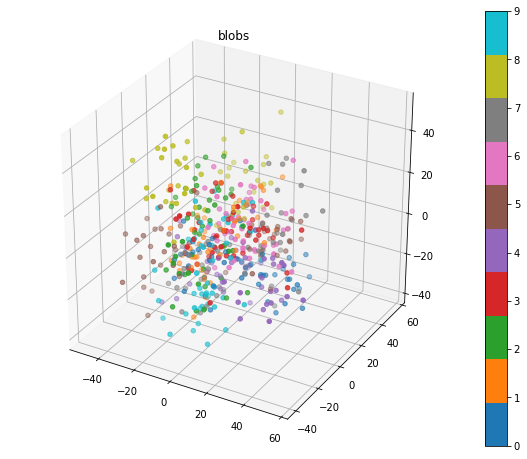

In [29]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('blobs')
p = ax.scatter(*X3d.T,c=y, cmap='tab10')
plt.colorbar(p)

### Sanity check: Simple neural net
Checking how an 8 neuron 1 hidden layer MLP solves the problem. 20% of training data is held out as validation for deciding on early stopping neural network training.

In [30]:
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
module = MLP(X.shape[1], 50, N, drop_proba=0.5)
simple_model = NNClassifier(
    module=module,
    max_epochs=100,
    batch_size=n_samples//5,
    lr=0.009,
    device='cuda',
    verbose=1,
    callbacks=[EarlyStopping(10, 'valid_loss'),
               NaNStopping()]
)

In [31]:
_ = simple_model.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        5.5197       0.1400        3.4567  0.1031
      2        4.5277       0.2100        2.8479  0.0168
      3        3.5870       0.2200        2.4646  0.0101
      4        3.2550       0.3000        2.1914  0.0106
      5        2.6271       0.3400        1.9988  0.0136
      6        2.3828       0.3800        1.8318  0.0140
      7        2.3055       0.3900        1.6925  0.0118
      8        2.0682       0.3800        1.6113  0.0120
      9        1.6013       0.3600        1.5441  0.0112
     10        1.6018       0.4300        1.4478  0.0135
     11        1.6127       0.4700        1.3961  0.0099
     12        1.4517       0.5100        1.3563  0.0090
     13        1.3771       0.5200        1.3132  0.0111
     14        1.3260       0.5100        1.2814  0.0095
     15        1.3460       0.5000        1.2414  0.0097
     16        1.1354       0.5

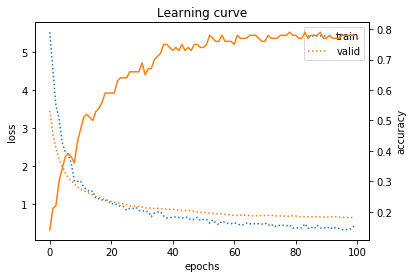

In [32]:
learning_curve(simple_model)

Text(0.5,0,'principal component 2')

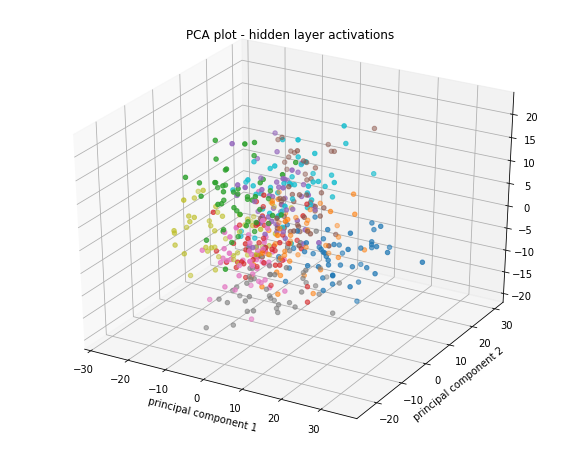

In [33]:
ksi = simple_model.transform(X, name='hidden1')
y_pred = simple_model.predict(X)
ksi2d = PCA(n_components=3).fit_transform(ksi)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('PCA plot - hidden layer activations')
ax.scatter(*ksi2d.T, c=y, cmap='tab10')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
#plt.zlabel('principal component 3')


## Training LDMNet
Here we train LDMNet based on the same MLP as before. Same early stopping heuristics apply.

In [34]:
torch.cuda.manual_seed(random_state)

max_epochs = 300

The network trains for `max_epochs`={{max_epochs}}, but can be early stopped if the validation loss does not improve.

In [35]:
module = MLP(X.shape[1], 50, N, drop_proba=0)
model = ProtoRegNet(
    module=module,
    layer_name='hidden1',
    max_epochs=max_epochs,
    batch_size=n_samples//5,
    lr=0.009,
    n_proto=20, reg=0.25,
    device='cuda',
    verbose=1,
    callbacks=[EarlyStopping(10, 'valid_loss'),
               NaNStopping(), 
               SaveWeights(every_n_epochs=5),
               SaveProtoRegNetVars(every_n_epochs=5)]
)

### Hyper parameters - random search
We choose to adjust the learning rate `lr`, the ADMM mutiplier `mu` and the regularization parameter `lambda_bar` ($\tilde{\lambda}$ in the paper). 20% of training is held out as validation data to evaluate each parameter set.

In [36]:
n_hparams = 5

params = {
'lr': uniform(1e-4, 1e-2),
'reg': reciprocal(1e-3, 2.0),
#'n_proto': randint(2, 20)
}

search = RandomizedSearchCV(
    model, n_iter=n_hparams, n_jobs=1,
    cv=StratifiedShuffleSplit(1, test_size=0.2, random_state=random_state),
    refit=True, random_state=random_state,
    param_distributions=params, verbose=1)

We search for `n_hparams`={{n_hparams}} sets of hyper-parameters.

In [37]:
import os
DIR = 'ProtoRegNetBlobs/%d_hparams_%d_max_epochs/' % (n_hparams, max_epochs)
FILE = 'save.pkl'
os.makedirs(DIR, exist_ok=True)
fname = os.path.join(DIR, FILE)
if not os.path.exists(fname) or 1:
    search.fit(X,y)
    pd.to_pickle({'search': search}, fname)
else:
    saved = pd.read_pickle(fname)
    search = saved['search']
model = search.best_estimator_

Fitting 1 folds for each of 5 candidates, totalling 5 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.2333       0.2125        3.6008  0.0329
      2        3.5005       0.2625        3.2450  0.0294
      3        3.0113       0.3125        2.9733  0.0142
      4        2.6456       0.3500        2.7634  0.0158
      5        2.3628       0.3750        2.5980  0.0169
      6        2.1374       0.4125        2.4626  0.0167
      7        1.9535       0.4250        2.3493  0.0156
      8        1.8007       0.4500        2.2533  0.0152
      9        1.6714       0.4750        2.1705  0.0161
     10        1.5606       0.5125        2.0988  0.0158
     11        1.4647       0.5125        2.0355  0.0154
     12        1.3806       0.5125        1.9795  0.0160
     13        1.3065       0.5250        1.9291  0.0139
     14        1.2409       0.5250        1.8835  0.0125
     15        1.1825       0

    106        0.4486       0.7125        1.2491  0.0185
    107        0.4476       0.7125        1.2479  0.0239
    108        0.4467       0.7250        1.2467  0.0222
    109        0.4458       0.7250        1.2456  0.0145
    110        0.4449       0.7250        1.2445  0.0166
    111        0.4441       0.7250        1.2433  0.0155
    112        0.4432       0.7250        1.2423  0.0140
    113        0.4423       0.7250        1.2412  0.0140
    114        0.4415       0.7250        1.2400  0.0163
    115        0.4407       0.7250        1.2390  0.0133
    116        0.4399       0.7250        1.2379  0.0128
    117        0.4390       0.7250        1.2369  0.0169
    118        0.4382       0.7250        1.2358  0.0125
    119        0.4375       0.7250        1.2348  0.0121
    120        0.4367       0.7250        1.2338  0.0132
    121        0.4359       0.7250        1.2328  0.0151
    122        0.4352       0.7250        1.2318  0.0178
    123        0.4344       0.7

    215        0.3859       0.7375        1.1707  0.0139
    216        0.3855       0.7375        1.1703  0.0215
    217        0.3851       0.7375        1.1698  0.0123
    218        0.3847       0.7375        1.1694  0.0338
    219        0.3843       0.7375        1.1689  0.0198
    220        0.3839       0.7375        1.1685  0.0157
    221        0.3835       0.7375        1.1681  0.0160
    222        0.3831       0.7375        1.1676  0.0157
    223        0.3827       0.7375        1.1672  0.0148
    224        0.3823       0.7375        1.1668  0.0225
    225        0.3819       0.7375        1.1664  0.0143
    226        0.3815       0.7375        1.1659  0.0279
    227        0.3811       0.7375        1.1655  0.0194
    228        0.3807       0.7375        1.1651  0.0196
    229        0.3803       0.7375        1.1647  0.0188
    230        0.3800       0.7375        1.1642  0.0165
    231        0.3796       0.7375        1.1638  0.0164
    232        0.3792       0.7

     22        0.5573       0.6000        1.2933  0.0120
     23        0.5325       0.6000        1.2742  0.0123
     24        0.5097       0.6000        1.2567  0.0134
     25        0.4886       0.6125        1.2405  0.0124
     26        0.4693       0.6125        1.2255  0.0122
     27        0.4512       0.6125        1.2118  0.0130
     28        0.4345       0.6125        1.1991  0.0136
     29        0.4189       0.6125        1.1873  0.0153
     30        0.4045       0.6125        1.1761  0.0145
     31        0.3910       0.6250        1.1657  0.0117
     32        0.3785       0.6250        1.1558  0.0137
     33        0.3669       0.6375        1.1466  0.0155
     34        0.3560       0.6375        1.1378  0.0172
     35        0.3457       0.6375        1.1294  0.0145
     36        0.3361       0.6375        1.1216  0.0144
     37        0.3271       0.6500        1.1141  0.0122
     38        0.3186       0.6625        1.1071  0.0155
     39        0.3107       0.6

    130        0.1510       0.7500        0.9135  0.0146
    131        0.1507       0.7500        0.9127  0.0209
    132        0.1504       0.7500        0.9120  0.0131
    133        0.1501       0.7500        0.9112  0.0260
    134        0.1497       0.7500        0.9105  0.0150
    135        0.1494       0.7500        0.9098  0.0151
    136        0.1491       0.7500        0.9090  0.0143
    137        0.1488       0.7625        0.9083  0.0135
    138        0.1485       0.7625        0.9076  0.0158
    139        0.1483       0.7625        0.9069  0.0172
    140        0.1480       0.7625        0.9062  0.0164
    141        0.1477       0.7625        0.9055  0.0175
    142        0.1474       0.7625        0.9048  0.0138
    143        0.1472       0.7625        0.9042  0.0168
    144        0.1469       0.7625        0.9035  0.0132
    145        0.1466       0.7625        0.9029  0.0148
    146        0.1464       0.7625        0.9022  0.0123
    147        0.1461       0.7

    240        0.1323       0.7500        0.8614  0.0151
    241        0.1322       0.7500        0.8611  0.0144
    242        0.1321       0.7500        0.8608  0.0125
    243        0.1320       0.7500        0.8605  0.0135
    244        0.1319       0.7500        0.8602  0.0120
    245        0.1318       0.7500        0.8599  0.0137
    246        0.1317       0.7500        0.8596  0.0120
    247        0.1316       0.7500        0.8594  0.0122
    248        0.1315       0.7625        0.8591  0.0148
    249        0.1315       0.7625        0.8588  0.0141
    250        0.1314       0.7625        0.8586  0.0119
    251        0.1313       0.7625        0.8583  0.0153
    252        0.1312       0.7625        0.8580  0.0128
    253        0.1311       0.7625        0.8578  0.0113
    254        0.1310       0.7625        0.8575  0.0125
    255        0.1309       0.7625        0.8572  0.0122
    256        0.1309       0.7625        0.8570  0.0137
    257        0.1308       0.7

     46        0.5023       0.6250        1.2884  0.0146
     47        0.4945       0.6250        1.2821  0.0148
     48        0.4870       0.6250        1.2761  0.0128
     49        0.4798       0.6375        1.2702  0.0124
     50        0.4729       0.6375        1.2646  0.0128
     51        0.4664       0.6500        1.2591  0.0195
     52        0.4601       0.6625        1.2538  0.0161
     53        0.4541       0.6625        1.2488  0.0249
     54        0.4483       0.6625        1.2439  0.0240
     55        0.4428       0.6625        1.2393  0.0271
     56        0.4376       0.6625        1.2348  0.0189
     57        0.4325       0.6625        1.2306  0.0151
     58        0.4276       0.6750        1.2264  0.0278
     59        0.4230       0.6750        1.2224  0.0227
     60        0.4185       0.6750        1.2185  0.0134
     61        0.4142       0.6750        1.2147  0.0125
     62        0.4101       0.6750        1.2111  0.0133
     63        0.4061       0.6

    155        0.2873       0.7500        1.0702  0.0143
    156        0.2869       0.7500        1.0695  0.0154
    157        0.2865       0.7500        1.0687  0.0139
    158        0.2861       0.7500        1.0680  0.0122
    159        0.2857       0.7500        1.0674  0.0134
    160        0.2853       0.7500        1.0667  0.0158
    161        0.2849       0.7500        1.0660  0.0140
    162        0.2845       0.7625        1.0653  0.0127
    163        0.2841       0.7625        1.0647  0.0171
    164        0.2837       0.7625        1.0640  0.0122
    165        0.2833       0.7625        1.0634  0.0143
    166        0.2829       0.7625        1.0627  0.0123
    167        0.2826       0.7625        1.0621  0.0131
    168        0.2822       0.7625        1.0614  0.0145
    169        0.2818       0.7625        1.0608  0.0158
    170        0.2815       0.7625        1.0602  0.0140
    171        0.2811       0.7625        1.0595  0.0137
    172        0.2808       0.7

    264        0.2585       0.7750        1.0204  0.0142
    265        0.2584       0.7750        1.0201  0.0147
    266        0.2582       0.7750        1.0199  0.0137
    267        0.2580       0.7750        1.0196  0.0203
    268        0.2578       0.7750        1.0193  0.0160
    269        0.2577       0.7750        1.0191  0.0115
    270        0.2575       0.7750        1.0188  0.0156
    271        0.2573       0.7750        1.0185  0.0127
    272        0.2571       0.7750        1.0183  0.0142
    273        0.2570       0.7750        1.0180  0.0133
    274        0.2568       0.7750        1.0177  0.0148
    275        0.2566       0.7750        1.0175  0.0119
    276        0.2564       0.7750        1.0172  0.0168
    277        0.2563       0.7750        1.0170  0.0179
    278        0.2561       0.7750        1.0167  0.0127
    279        0.2559       0.7750        1.0165  0.0120
    280        0.2558       0.7750        1.0162  0.0234
    281        0.2556       0.7

     70        1.4466       0.6500        2.3394  0.0132
     71        1.4406       0.6500        2.3345  0.0252
     72        1.4347       0.6625        2.3296  0.0139
     73        1.4289       0.6625        2.3249  0.0143
     74        1.4231       0.6625        2.3201  0.0126
     75        1.4175       0.6625        2.3155  0.0143
     76        1.4120       0.6625        2.3109  0.0119
     77        1.4065       0.6625        2.3064  0.0143
     78        1.4012       0.6625        2.3020  0.0143
     79        1.3959       0.6625        2.2977  0.0146
     80        1.3908       0.6625        2.2933  0.0144
     81        1.3857       0.6625        2.2891  0.0106
     82        1.3806       0.6625        2.2850  0.0140
     83        1.3757       0.6625        2.2810  0.0128
     84        1.3708       0.6625        2.2768  0.0128
     85        1.3660       0.6625        2.2728  0.0138
     86        1.3613       0.6625        2.2691  0.0135
     87        1.3567       0.6

    179        1.0751       0.7375        2.0335  0.0131
    180        1.0729       0.7375        2.0317  0.0149
    181        1.0708       0.7375        2.0299  0.0251
    182        1.0686       0.7375        2.0283  0.0144
    183        1.0664       0.7375        2.0266  0.0160
    184        1.0643       0.7375        2.0249  0.0130
    185        1.0622       0.7375        2.0231  0.0121
    186        1.0601       0.7375        2.0216  0.0132
    187        1.0580       0.7375        2.0199  0.0123
    188        1.0559       0.7375        2.0182  0.0166
    189        1.0538       0.7375        2.0166  0.0140
    190        1.0517       0.7375        2.0150  0.0121
    191        1.0496       0.7375        2.0132  0.0139
    192        1.0476       0.7375        2.0116  0.0142
    193        1.0455       0.7375        2.0099  0.0217
    194        1.0435       0.7375        2.0082  0.0138
    195        1.0414       0.7375        2.0066  0.0146
    196        1.0394       0.7

    289        0.8816       0.7250        1.8899  0.0156
    290        0.8802       0.7250        1.8888  0.0130
    291        0.8788       0.7250        1.8878  0.0133
    292        0.8774       0.7125        1.8868  0.0119
    293        0.8759       0.7125        1.8857  0.0151
    294        0.8745       0.7125        1.8849  0.0120
    295        0.8731       0.7125        1.8838  0.0175
    296        0.8717       0.7125        1.8826  0.0124
    297        0.8703       0.7125        1.8818  0.0139
    298        0.8689       0.7125        1.8809  0.0145
    299        0.8675       0.7125        1.8800  0.0143
    300        0.8661       0.7125        1.8790  0.0122
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7313       0.2875        2.9878  0.0118
      2        2.7064       0.3375        2.4991  0.0154
      3        2.0954       0.3875        2.1847  0.0133
      4        1.6935       0.4

     95        0.0613       0.7500        0.8061  0.0250
     96        0.0610       0.7500        0.8051  0.0286
     97        0.0606       0.7500        0.8042  0.0139
     98        0.0603       0.7500        0.8032  0.0158
     99        0.0600       0.7500        0.8023  0.0132
    100        0.0597       0.7500        0.8014  0.0187
    101        0.0594       0.7500        0.8005  0.0132
    102        0.0591       0.7500        0.7997  0.0142
    103        0.0588       0.7500        0.7988  0.0134
    104        0.0585       0.7500        0.7979  0.0140
    105        0.0583       0.7500        0.7971  0.0136
    106        0.0580       0.7500        0.7963  0.0128
    107        0.0577       0.7500        0.7955  0.0131
    108        0.0575       0.7500        0.7947  0.0138
    109        0.0572       0.7500        0.7939  0.0133
    110        0.0570       0.7500        0.7931  0.0137
    111        0.0567       0.7500        0.7923  0.0129
    112        0.0565       0.7

    205        0.0461       0.7500        0.7478  0.0149
    206        0.0460       0.7500        0.7475  0.0134
    207        0.0460       0.7500        0.7472  0.0285
    208        0.0459       0.7625        0.7469  0.0293
    209        0.0459       0.7625        0.7466  0.0167
    210        0.0458       0.7625        0.7463  0.0350
    211        0.0458       0.7625        0.7461  0.0191
    212        0.0457       0.7625        0.7458  0.0332
    213        0.0457       0.7625        0.7455  0.0240
    214        0.0456       0.7625        0.7452  0.0234
    215        0.0456       0.7625        0.7449  0.0138
    216        0.0455       0.7625        0.7447  0.0150
    217        0.0455       0.7625        0.7444  0.0182
    218        0.0454       0.7625        0.7441  0.0171
    219        0.0454       0.7625        0.7439  0.0181
    220        0.0453       0.7625        0.7436  0.0222
    221        0.0453       0.7625        0.7433  0.0170
    222        0.0452       0.7

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.8s finished


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.5189       0.1800        3.1885  0.0211
      2        2.5530       0.2300        2.6641  0.0525
      3        1.9917       0.2800        2.3250  0.0198
      4        1.6101       0.3400        2.0844  0.0263
      5        1.3349       0.3800        1.9052  0.0225
      6        1.1299       0.4700        1.7677  0.0409
      7        0.9732       0.4700        1.6581  0.0207
      8        0.8495       0.5100        1.5688  0.0213
      9        0.7490       0.5400        1.4949  0.0216
     10        0.6670       0.5600        1.4332  0.0213
     11        0.5990       0.5800        1.3805  0.0211
     12        0.5414       0.6000        1.3356  0.0232
     13        0.4924       0.6000        1.2964  0.0169
     14        0.4504       0.6000        1.2624  0.0180
     15        0.4140       0.6100        1.2318  0.0177
     16        0.3822       0.6

    106        0.0556       0.7600        0.7705  0.0168
    107        0.0553       0.7600        0.7696  0.0175
    108        0.0551       0.7600        0.7687  0.0168
    109        0.0548       0.7600        0.7678  0.0178
    110        0.0546       0.7600        0.7669  0.0166
    111        0.0544       0.7600        0.7660  0.0134
    112        0.0541       0.7600        0.7651  0.0176
    113        0.0539       0.7600        0.7642  0.0147
    114        0.0537       0.7600        0.7634  0.0154
    115        0.0535       0.7600        0.7626  0.0162
    116        0.0533       0.7700        0.7618  0.0192
    117        0.0531       0.7700        0.7610  0.0145
    118        0.0529       0.7700        0.7602  0.0162
    119        0.0527       0.7700        0.7594  0.0147
    120        0.0525       0.7700        0.7587  0.0290
    121        0.0523       0.7700        0.7579  0.0162
    122        0.0521       0.7700        0.7572  0.0203
    123        0.0519       0.7

    215        0.0434       0.7900        0.7166  0.0160
    216        0.0433       0.7900        0.7164  0.0176
    217        0.0433       0.7900        0.7161  0.0161
    218        0.0432       0.7900        0.7159  0.0176
    219        0.0432       0.7900        0.7156  0.0153
    220        0.0431       0.7900        0.7154  0.0261
    221        0.0431       0.7900        0.7151  0.0283
    222        0.0430       0.7900        0.7149  0.0148
    223        0.0430       0.7900        0.7146  0.0148
    224        0.0429       0.7900        0.7144  0.0149
    225        0.0429       0.7900        0.7141  0.0156
    226        0.0429       0.7900        0.7139  0.0169
    227        0.0428       0.7900        0.7136  0.0302
    228        0.0428       0.7900        0.7134  0.0199
    229        0.0427       0.7900        0.7132  0.0172
    230        0.0427       0.7900        0.7129  0.0189
    231        0.0427       0.7900        0.7127  0.0175
    232        0.0426       0.7

#### Hyper-parameters - best set
The model is retrained over the complete training set using the best parameters found. Here are the parameters and the accuracy over the training set.

In [38]:
model = search.best_estimator_
print("best params", search.best_params_)
print("validation accuracy", model.score(X, y))

best params {'lr': 0.009736627605010293, 'reg': 0.018439619501993142}
validation accuracy 0.96


#### Hyper-parameters - best parameter sets in the hyper-parameter space
Here only the other parameter-sets yielding validation accuracy better than 90%

In [39]:
results = search.cv_results_
results = pd.DataFrame(results)
df=pd.DataFrame(results, columns=['param_' + p for p in params.keys()])

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


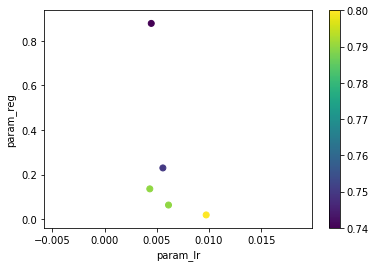

In [40]:
fig = plt.figure()
mask = results.mean_test_score.values > 0
#ax = fig.add_subplot(111, projection='3d')
ax = plt.gca()
p = ax.scatter(*df.values[mask].T, c=results.mean_test_score.values[mask], cmap='viridis')
#set_labels = lambda x, y, z: (ax.set_xlabel(x), ax.set_ylabel(y), ax.set_zlabel(z))
set_labels = lambda x, y: (ax.set_xlabel(x), ax.set_ylabel(y))
set_labels(*df.columns.values)
plt.colorbar(p)

### Observing LDMNet training

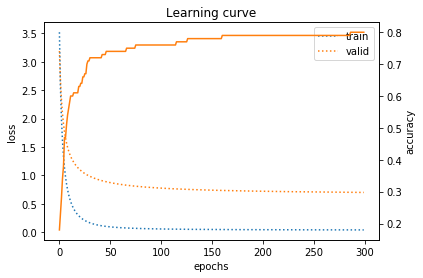

In [41]:
learning_curve(model)

#### PCA plots of feature space ksi
Here we plot 2D - PCA views of the hidden layer activations -- `ksi`-- and of the perturbed coordinate functions `alpha` to which they are regularized, as the iterations proceed.

In [42]:
%run LDMM_plot_utils.py

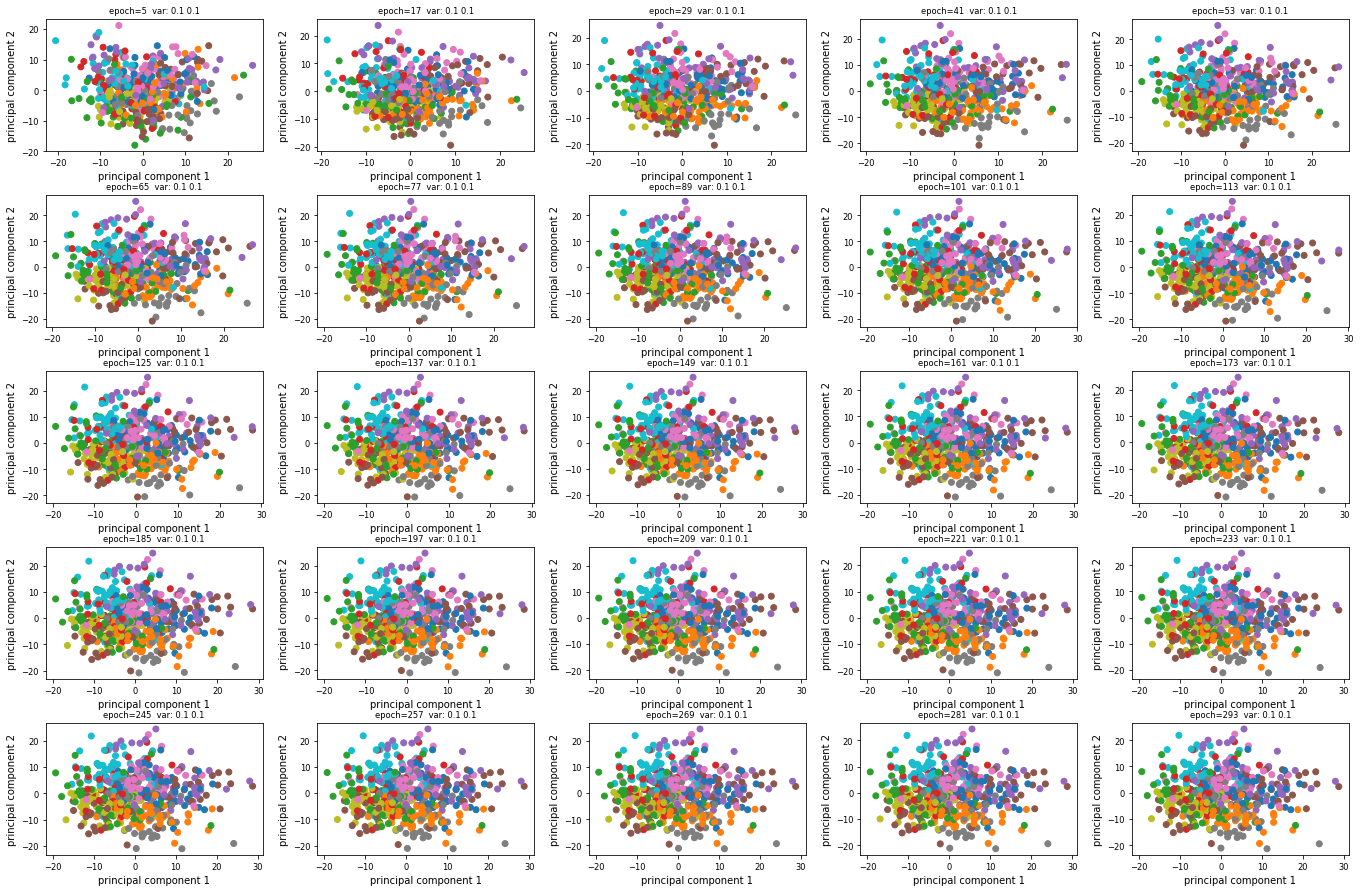

In [43]:
plt.rcParams['image.cmap'] = 'RdBu'
out = plot_over_time(model, 'ksi', every_n=2, y=y, cmap='tab10')
plt.tight_layout(h_pad=0.1)

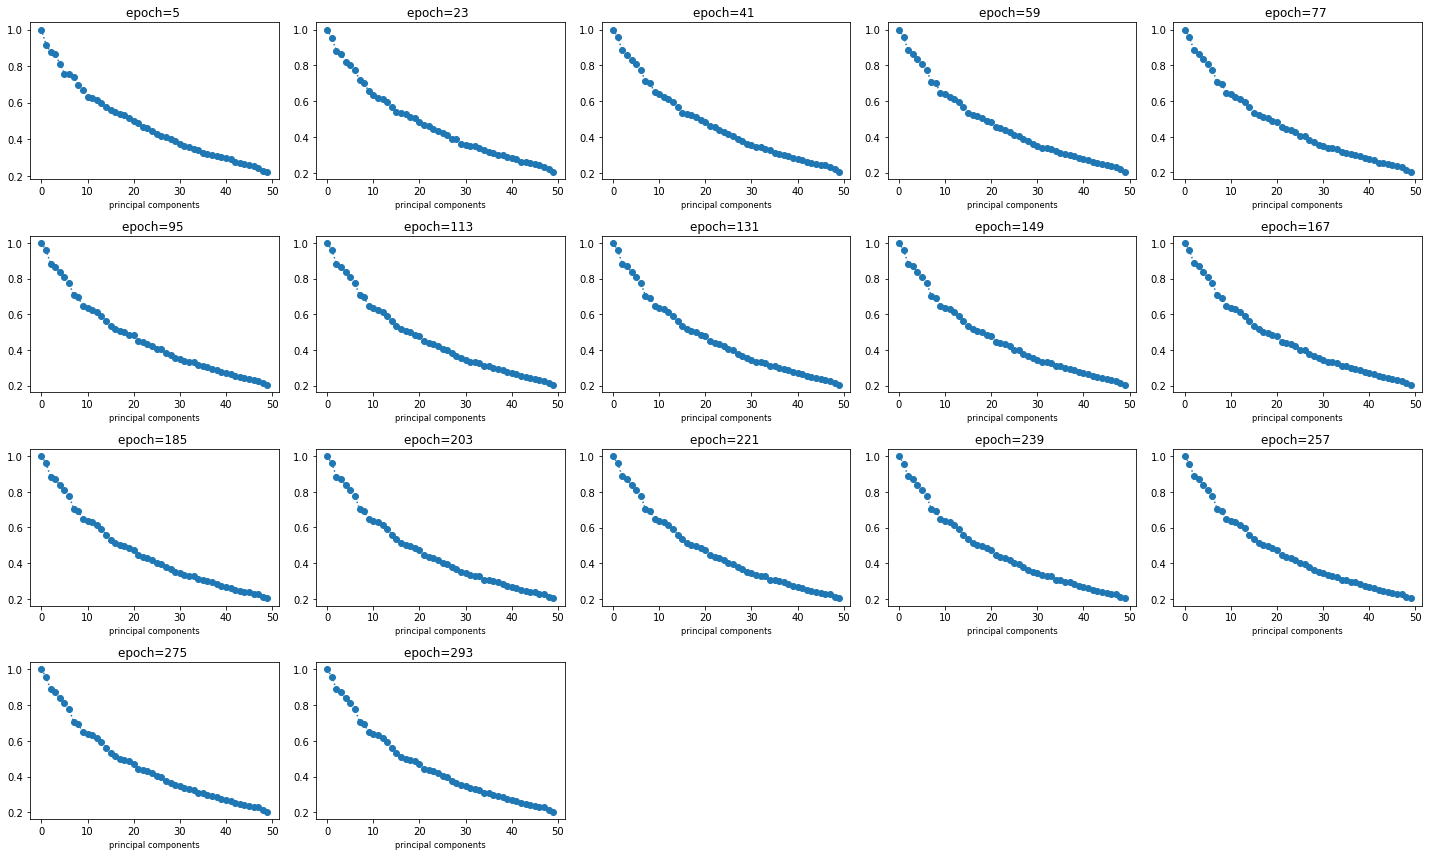

In [44]:
_ = plot_sv_over_time(model, 'ksi')

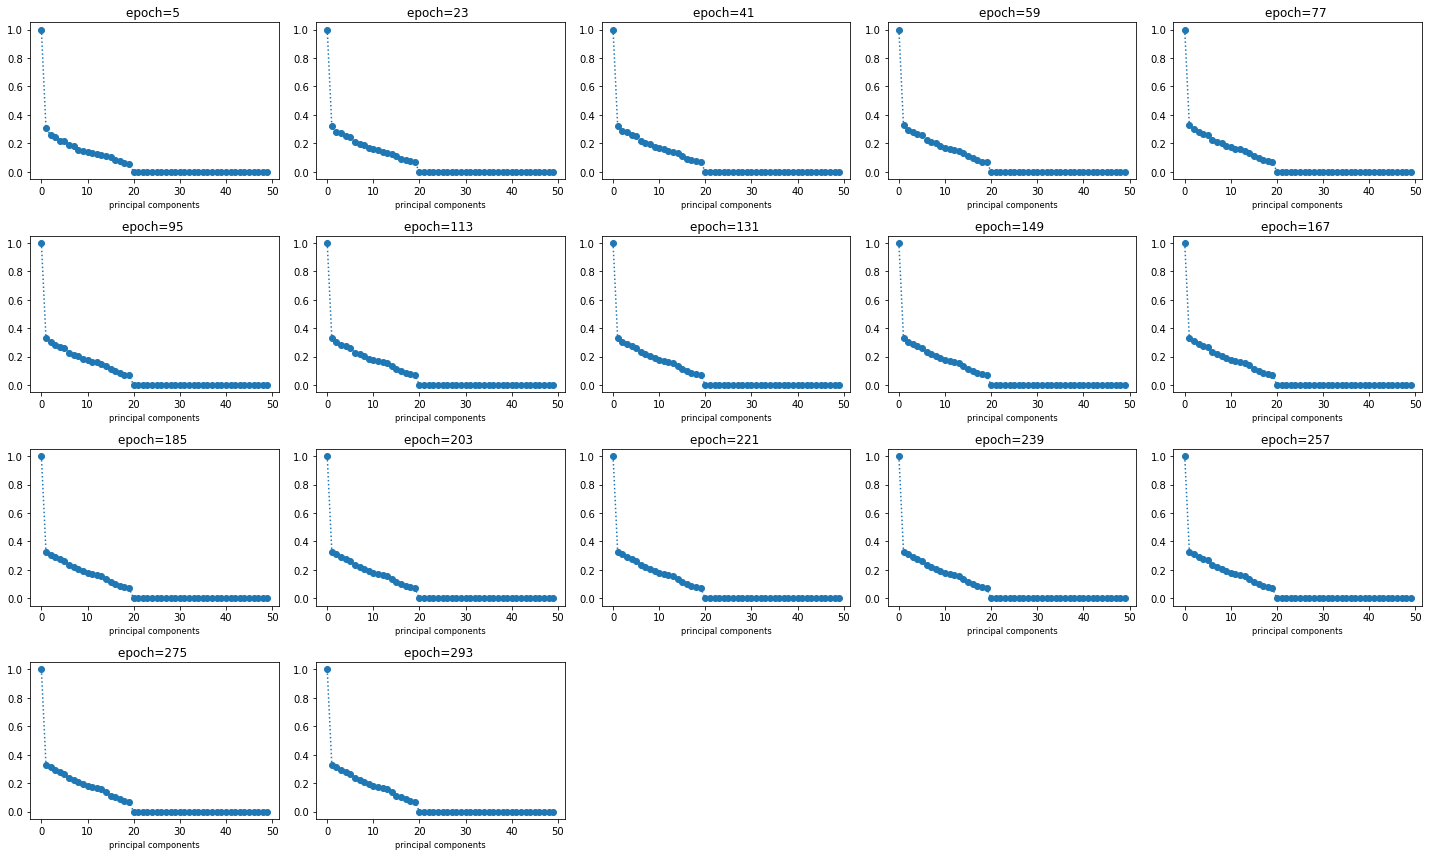

In [45]:
_ = plot_sv_over_time(model, 'alpha')

In this plot, the PCA is calculated at each time step for `alpha` and the same projection is used to plot `ksi`. The idea is to see in a common space how different were `ksi` and `alpha` during the optimization.

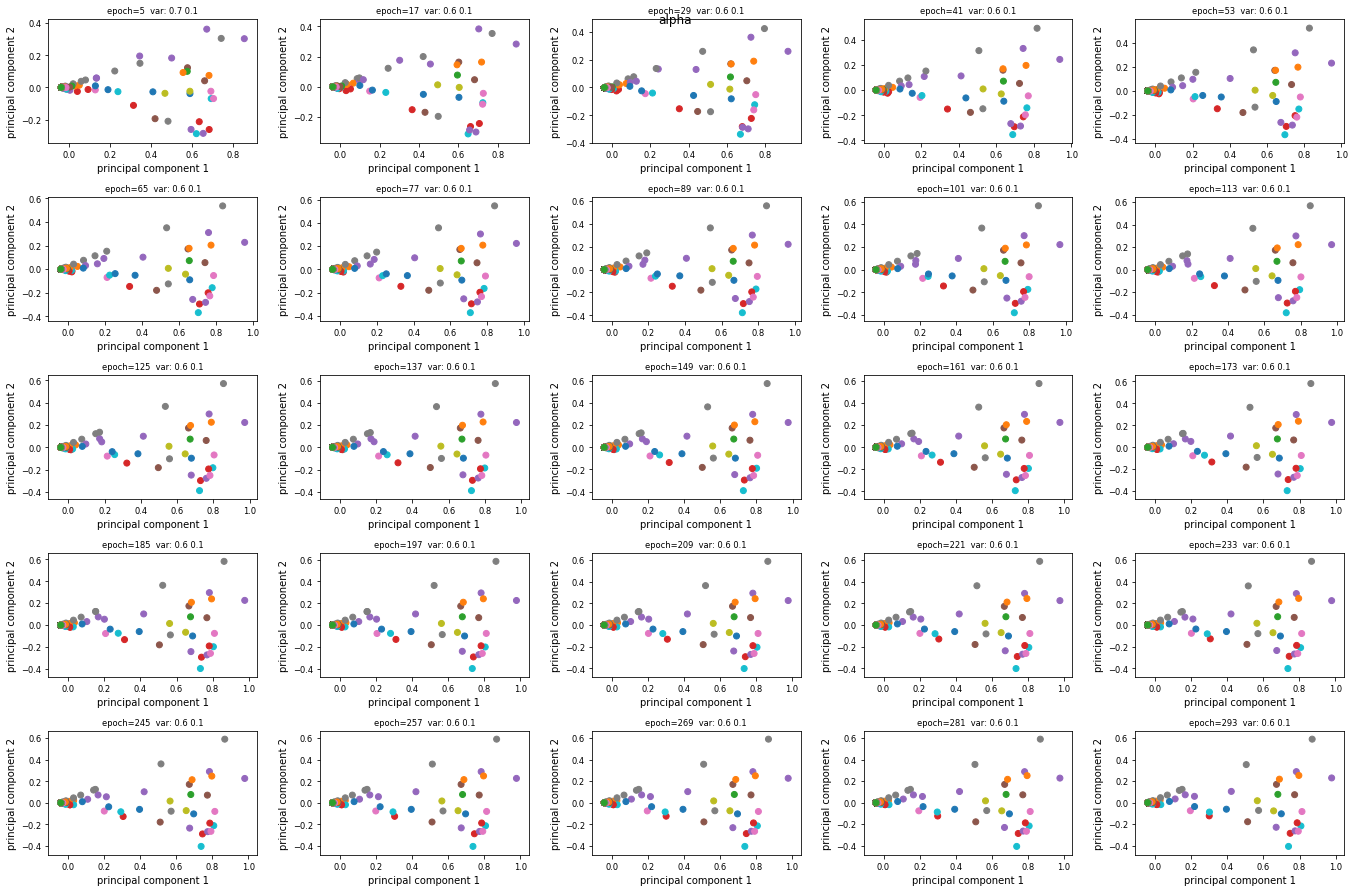

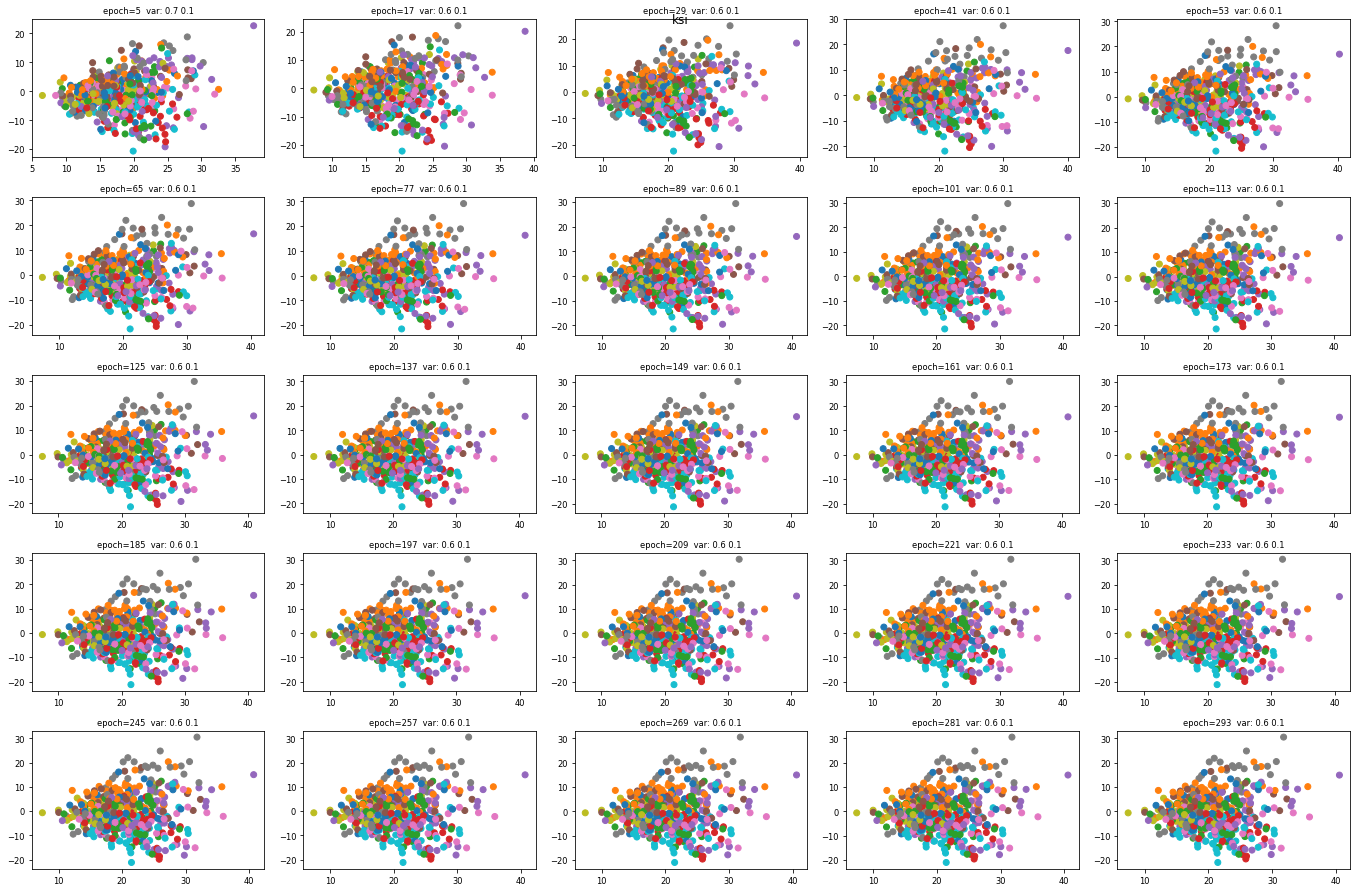

In [46]:
plot_ksi_alpha_time(model, every_n=2, y=y, cmap='tab10')
#plt.tight_layout(h_pad=0.1)

#### Average values per feature along the iterations
To get a sense of the convergence, here we plot average values per feature (i.e. per neuron of the hidden layer) of : 
- `alpha`
- dual variable `Z`
- activations `ksi`
- weights and bias of the hidden and output layers

We also plot their variations -- delta -- along the iterations. A smothing window is used for delta `alpha` and delta `Z`.
##### Evolution of Z, alpha and ksi

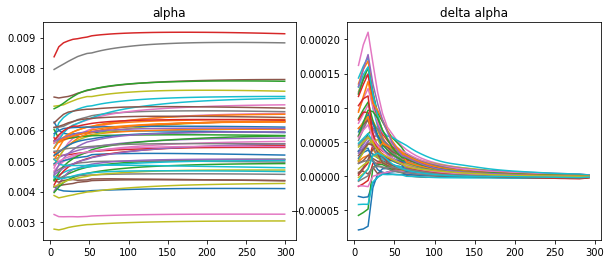

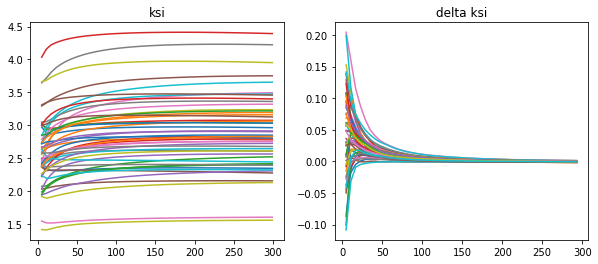

In [47]:
# plot_ldmm_vars(model, 'Z', smooth_delta=5)
plot_ldmm_vars(model, 'alpha', smooth_delta=5)
plot_ldmm_vars(model, 'ksi', smooth_delta=0)

##### Evolution of weights and bias 

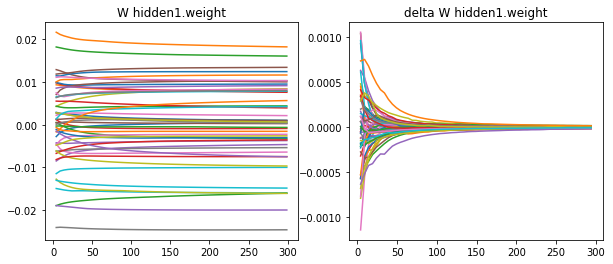

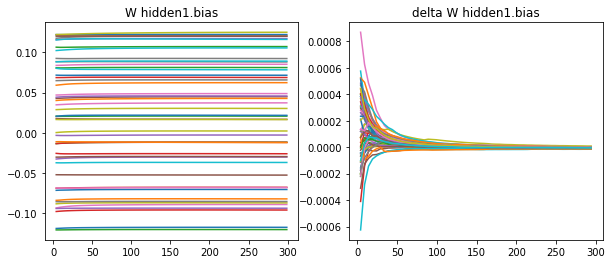

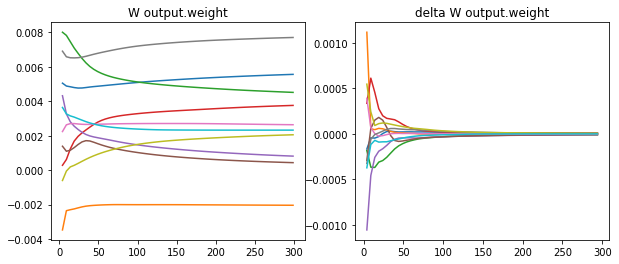

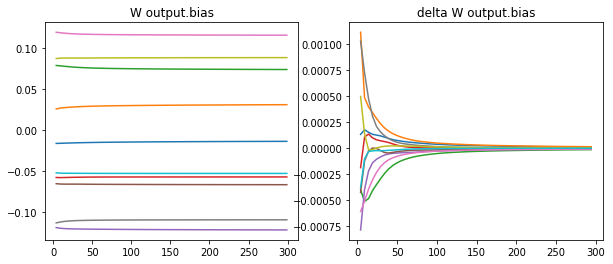

In [48]:
plot_net_weights(model, 'hidden1', smooth_delta=0)
plot_net_weights(model, 'output', smooth_delta=0)